# Run scGen

add class documentation

In [26]:
# Importing necessary libraries
import pertpy as pp
import scanpy as sc
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('./')
from scGen_class import scGenPerturbationAnalysis

In [2]:
# Loading the dataset
covid_data = pp.dt.stephenson_2021_subsampled()
#covid_data = sc.read('data/stephenson_2021_subsampled.h5ad')

In [ ]:
# input parameters
condition_col= "time_after_LPS" #or "disease" in case COVID vs normal
ctrl_key = "nan"
stim_key = "10h" # early LPS "90m"
celltype_col = "author_cell_type" # "cell_type"
celltype_to_predict = "B_naive"
n_epochs = 20
n_comps = 50 # n_comps for PCA and distance metric calculation

In [4]:
# filter the data set to have pairwise comparison 
LPSN_data = covid_data[((covid_data.obs["disease"] == "normal"))]
LPSN_data = LPSN_data[(LPSN_data.obs[condition_col].isin([ctrl_key, stim_key]))]

In [5]:
#downsample the data set
sc.pp.subsample(LPSN_data, n_obs=3000)

In [6]:
# Filter data for control and stimulated conditions
ctrl_data = LPSN_data[LPSN_data.obs[condition_col] == ctrl_key]
stim_data = LPSN_data[LPSN_data.obs[condition_col] == stim_key]

# Get unique cell types for each condition
ctrl_celltypes = set(ctrl_data.obs[celltype_col].unique())
stim_celltypes = set(stim_data.obs[celltype_col].unique())

# Find the intersection (cell types present in both conditions)
common_celltypes = list(ctrl_celltypes.intersection(stim_celltypes))

print(common_celltypes)
len(common_celltypes)

['MAIT', 'CD4.IL22', 'Plasmablast', 'Platelets', 'CD8.EM', 'Plasma_cell_IgM', 'B_exhausted', 'CD4.Naive', 'B_immature', 'B_naive', 'CD8.TE', 'B_non-switched_memory', 'CD4.CM', 'Plasma_cell_IgG', 'CD8.Naive', 'gdT', 'B_switched_memory', 'NK_56hi', 'NK_16hi']


19

In [7]:
combined_counts = LPSN_data.obs.groupby([celltype_col,condition_col]).size() 
combined_counts_df = combined_counts.reset_index(name='counts')
combined_counts_df

/var/folders/13/yntv3wyn4v90z0vh3fcqrckm0000gn/T/ipykernel_52479/2931515266.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_counts = LPSN_data.obs.groupby([celltype_col,condition_col]).size()


,author_cell_type,time_after_LPS,counts
0,ASDC,10h,0
1,ASDC,nan,1
2,B_exhausted,10h,11
3,B_exhausted,nan,8
4,B_immature,10h,16
...,...,...,...
83,Treg,nan,1
84,gdT,10h,5
85,gdT,nan,89
86,pDC,10h,0


In [ ]:
# Initialize an empty list to store the results
results = []

for i in common_celltypes:

    celltype_to_predict = i

    # Instantiating the PerturbationAnalysis class with the loaded data
    analysis = scGenPerturbationAnalysis(LPSN_data)
    # Preprocessing the data
    analysis.preprocess_data(apply_log1p = False) #normalisation mandatory, and log1p optional... maybe test both
    analysis.prepare_training_set(condition_col, 
                                stim_key,
                                celltype_col,
                                celltype_to_predict)
    # Setting up AnnData for scGen
    analysis.setup_anndata(condition_col, 
                        celltype_col)
    analysis.train_model(max_epochs= n_epochs, batch_size=64)
    # Making predictions 
    analysis.make_prediction(
                            ctrl_key,
                            stim_key,
                            celltype_to_predict,
                            condition_col)
    # Evaluating the predictions
    analysis.evaluate_prediction(celltype_col,
                                celltype_to_predict,
                                condition_col,
                                ctrl_key,
                                stim_key)
    # Identifying differentially expressed genes
    analysis.identify_diff_genes(celltype_col,
                                celltype_to_predict,
                                condition_col,
                                stim_key)
    analysis.plot_mean_correlation(stim_key)
    
    # Get R2 value
    r2_value = analysis.r2_value

    # Computing the distance metric
    metric = "edistance"
    analysis.compute_distance_metric(n_comps,
                                    metric,
                                    condition_col,
                                    stim_key,
                                    ctrl_key)
    # Get the perturbation score
    e_distance = analysis.perturbation_score

    metric = "mmd"
    analysis.compute_distance_metric(n_comps,
                                    metric,
                                    condition_col,
                                    stim_key,
                                    ctrl_key)
    # Get the perturbation score
    mmd = analysis.perturbation_score #maximum mean distance

    metric = "euclidean"
    analysis.compute_distance_metric(n_comps,
                                    metric,
                                    condition_col,
                                    stim_key,
                                    ctrl_key)
    # Get the perturbation score
    euclidean = analysis.perturbation_score #maximum mean distance

    results.append({
            "celltype_to_predict": celltype_to_predict,
            "r2_value": r2_value,
            "e_distance": e_distance,
            "mmd": mmd,
            "euclidean": euclidean


        })
    

In [ ]:

results_df = pd.DataFrame(results)
results_df.to_csv("results_table_stephenson_20epochs_lateLPS.csv", index=False)


/var/folders/13/yntv3wyn4v90z0vh3fcqrckm0000gn/T/ipykernel_52479/3627144927.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/13/yntv3wyn4v90z0vh3fcqrckm0000gn/T/ipykernel_52479/3627144927.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/13/yntv3wyn4v90z0vh3fcqrckm0000gn/T/ipykernel_52479/3627144927.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/13/yntv3wyn4v90z0vh3fcqrckm0000gn/T/ipykernel_52479/3627144927.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

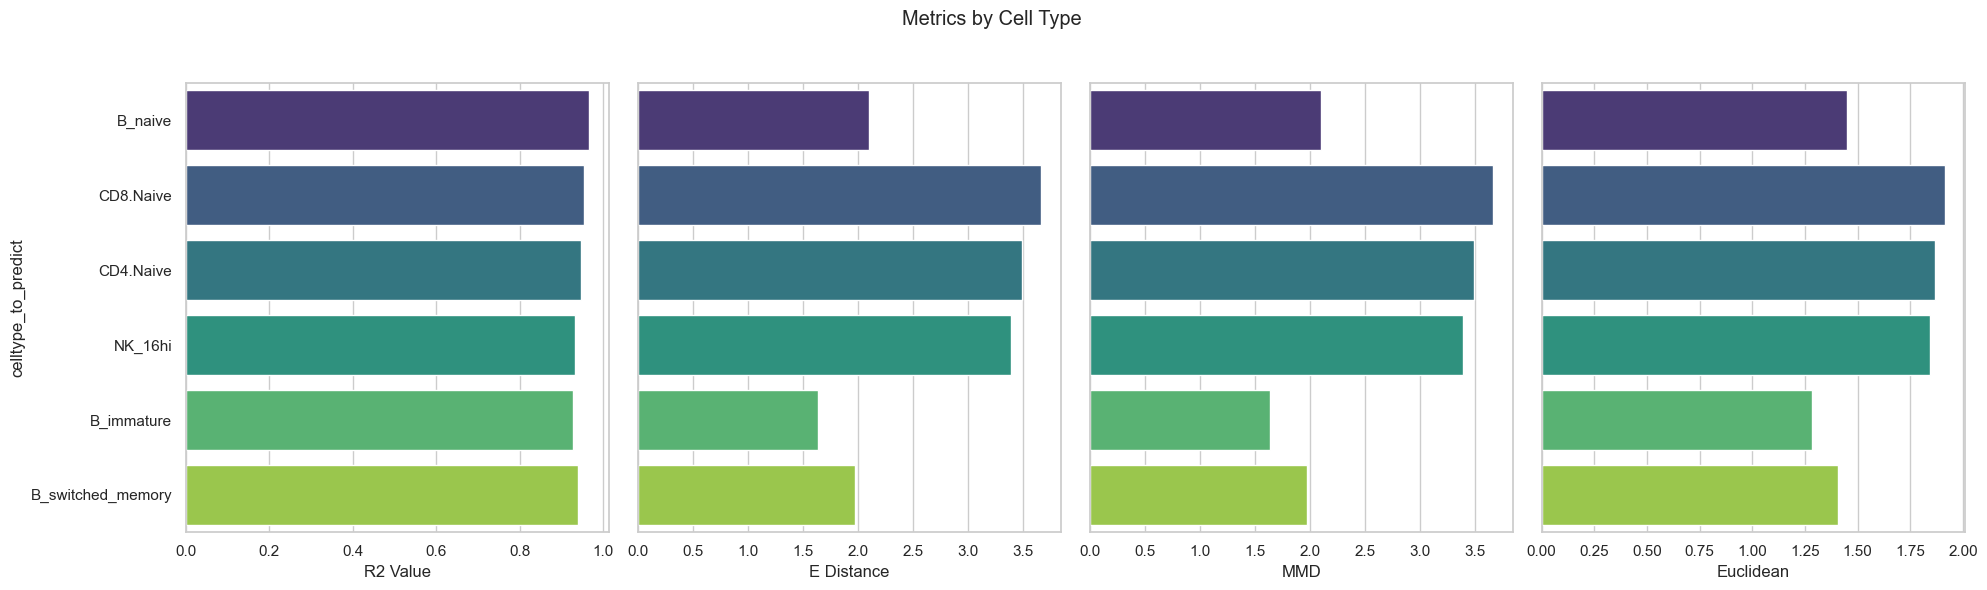

In [27]:
#evaluate results:
# Load the CSV file into a DataFrame
data = pd.read_csv("results_table_stephenson_20epochs_lateLPS.csv")

# Set up the plotting style and dimensions
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

# Define metrics and their labels for x-axis
metrics = ["r2_value", "e_distance", "mmd", "euclidean"]
x_labels = ["R2 Value", "E Distance", "MMD", "Euclidean"]

# Create a bar plot for each metric
for i, metric in enumerate(metrics):
    sns.barplot(
        y="celltype_to_predict", x=metric, data=data, ax=axes[i], palette="viridis"
    )
    axes[i].set_xlabel(x_labels[i])

# Set common title and show plot
plt.suptitle("Metrics by Cell Type")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()